In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from numba import jit
from timeit import default_timer as timer

## Naive Implementation
The naive implementation will be a simply approach using a for-loop to go through every position on the grid.

In [2]:
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    for i in range(p_im): # rows (y-axis)
        for j in range(p_re): # columns (x-axis)
            c = re[j] +1j * im[i] # create a starting point
            mset[i, j] = compute_mandelbrot(c, max_iters, threshold) # store the number of iterations before diverge
    return mset

In [ ]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

print("Computing Mandelbrot set...")
start_time = timer()
mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")

plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Vectorized implementation
The vectorized implementation, will handle all positions on the grid in parallel. This is done using a boolean mask to index the array, and continue the algorithm only on points which have not already diverged.

In [ ]:
def vector_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    C = re[np.newaxis, :] + 1j * im[:, np.newaxis] # create axis across columns for real part and rows for imaginary part
    
    z = np.copy(C) # populate z with starting points
    mset = np.zeros(C.shape) # array to store number of iterations before divergence
    
    for _ in range(max_iters):
        mask = np.abs(z) <= threshold
        z[mask] = z[mask]**2 + C[mask] # perform operation on points that have not diverged
        mset += mask # add +1 to all points with true in the mask
    return mset

In [ ]:
p_re = 5000
p_im = 5000
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

print("Computing Mandelbrot set...")
start_time = timer()
mset = vector_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")


plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Naive implementation using JIT
For this implementation JIT will be used to compile the naive implementation before running it. This is implemented using the JIT decorator, and should give a significant speed up for approaches using loops.

In [6]:
@jit(nopython = True, fastmath = True)
def jit_compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

@jit(nopython = True, fastmath = True)
def jit_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    for i in range(p_im): # rows (y-axis)
        for j in range(p_re): # columns (x-axis)
            c = re[j] +1j * im[i] # create a starting point
            mset[i, j] = jit_compute_mandelbrot(c, max_iters, threshold) # store the number of iterations before diverge
    return mset

Computing Mandelbrot set...
Execution time: 10.443633621005574s


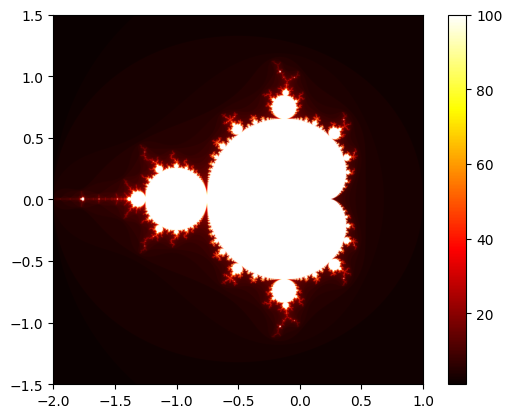

In [7]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

print("Computing Mandelbrot set...")
start_time = timer()
mset = jit_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")

plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Naive implementation using varying datatypes
This section will focus on speed up by explicitly changing the datatype.

In [14]:
# @jit(nopython = True, fastmath = True)
def dtypes_compute_mandelbrot(c, max_iters, threshold):
    z = type(c)(0) # use same type as c
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

# @jit(nopython = True, fastmath = True)
def dtypes_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, dtype_size):
    if dtype_size == 16:
        dtype_float = np.float16
        dtype_int = np.int16
        dtype_complex = np.complex64
    elif dtype_size == 32:
        dtype_float = np.float32
        dtype_int = np.int32
        dtype_complex = np.complex64
    elif dtype_size == 64:
        dtype_float = np.float64
        dtype_int = np.int64
        dtype_complex = np.complex128
    elif dtype_size == 128:
        dtype_float = np.float128
        dtype_int = np.int128
        dtype_complex = np.complex256
    
    re = np.linspace(re_min, re_max, p_re, dtype=dtype_float)
    im = np.linspace(im_min, im_max, p_im, dtype=dtype_float)
    
    mset = np.zeros((p_im, p_re), dtype=dtype_int) # create an array to store the mandelbrot set
    
    for i in range(p_im): # rows (y-axis)
        for j in range(p_re): # columns (x-axis)
            c = dtype_complex(complex(re[j], im[i])) # create a starting point
            mset[i, j] = dtypes_compute_mandelbrot(c, max_iters, threshold) # store the number of iterations before diverge
    return mset

Computing Mandelbrot set...
Execution time: 474.30218754100497s


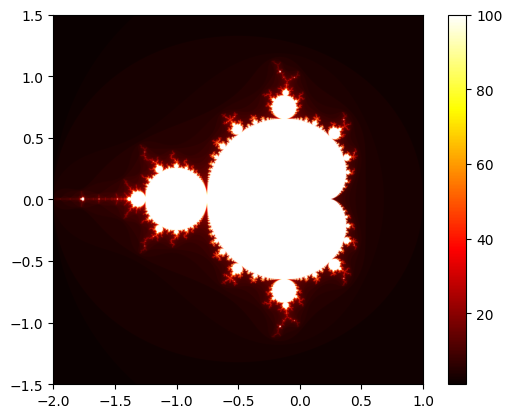

In [15]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

print("Computing Mandelbrot set...")
start_time = timer()
mset32 = dtypes_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, 32)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")

plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)